In [136]:
import matplotlib.pyplot as plt
import importlib
import bitmap_editor
importlib.reload(bitmap_editor)
import numpy as np

height = 30
width = 30
bitmap_matrix = np.zeros(shape=(height,width))
bitmapEditor = bitmap_editor.BitmapEditor(bitmap_matrix)

Canvas(height=600, width=600)

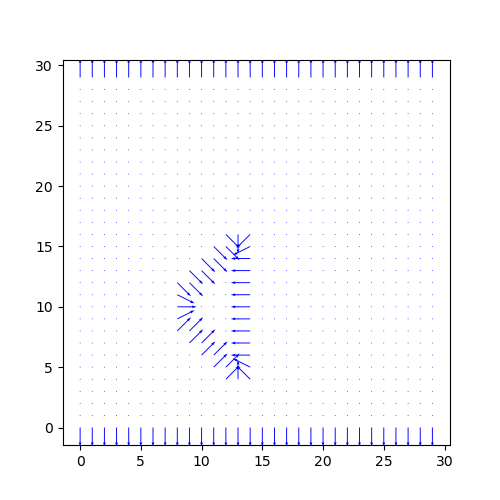

[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -4.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

In [141]:
import boundary_conditions

# def boundary_indices(matrix):
#     result = []
#     for j in range(1, matrix.shape[0]-1):
#         for i in range(1, matrix.shape[1]-1):
#             if matrix[j][i]:
#                 continue
#             if np.any(matrix[j-1:j+2,i-1:i+2]):
#                 result += [(j,i)]
#     return result

importlib.reload(boundary_conditions)

obstacle = np.flip(np.copy(bitmap_matrix),0)

from dataclasses import dataclass
from typing import Optional, Tuple
from numpy.typing import NDArray

@dataclass
class FluidCell:
    # Index in the 1D array of fluid cells.
    index: int
    # Index in the 2D grid, which also contains obstacle cells.
    grid_index: tuple[int, int]
    # Cells on the boundary have a unit normal pointing into the boundary.
    # TODO: If more boundary-specific fields are needed, create a subtype BoundaryCell.
    boundary_normal: Optional[NDArray] = None

fluid_cells = []

fluid_cell_count = 0

def boundary_normal(j,i, grid):
    if j == 0:
        return np.array([0, -1])
    if j == height-1:
        return np.array([0, 1])
    if i == 0 or i == width-1:
        return None
    neighborhood = grid[j-1:j+2, i-1:i+2]
    if not np.any(neighborhood):
        return None
    return boundary_conditions.boundary_normal(neighborhood)

for j in range(0, height):
    for i in range(0, width):
        if obstacle[j][i]:
            continue
        fluid_cells+= [FluidCell(
            index=fluid_cell_count,
            grid_index=(j,i),
            boundary_normal=boundary_normal(j,i,obstacle))]
        
boundary_indices = boundary_conditions.boundary_indices(obstacle)
normals = []

for index in boundary_indices:
    neighborhood = obstacle[index[0]-1:index[0]+2,index[1]-1:index[1]+2]
    normal = boundary_conditions.boundary_normal(neighborhood)
    normals += [normal]

for i in range(0,width):
    boundary_indices += [(0,i)]
    normals += [np.array([0,-1])]
    boundary_indices += [(height-1,i)]
    normals += [np.array([0,1])]

X, Y = np.meshgrid(np.arange(width), np.arange(height))
NormalsU = np.zeros(shape=(height, width))
NormalsV = np.zeros(shape=(height, width))
for index, normal in zip(boundary_indices, normals):
    NormalsU[index] = normal[0]
    NormalsV[index] = normal[1]

fig, ax = plt.subplots(figsize = (5, 5))
ax.quiver(X,Y, NormalsU, NormalsV, color='b',scale=20)
plt.show()

fluid_cell_flat_index = np.ones(shape=(height,width),dtype=int)*-1

fluid_cell_count = 0
for j in range(0,height):
    for i in range(0,width):
        if obstacle[j][i]:
            continue
        fluid_cell_flat_index[j][i] = fluid_cell_count
        fluid_cell_count+=1

# Make a flat array of structures for each fluid cell, 
# each structure specifies the linear equation for that cell.
A = np.zeros(shape=(fluid_cell_count, fluid_cell_count))
b = np.zeros(fluid_cell_count)

# Constant w
w = np.array([2,0])

boundary_indices_set = set(boundary_indices)

step = 1
for j in range(1,height-1):
    for i in range(0, width):
        if obstacle[j][i]:
            continue
        if (j,i) in boundary_indices_set:
            continue
        divW = 0
        equationNum = fluid_cell_flat_index[j][i]
        A[equationNum][fluid_cell_flat_index[j][i]] = -4
        A[equationNum][fluid_cell_flat_index[j-1][i]] = 1
        A[equationNum][fluid_cell_flat_index[j+1][i]] = 1
        A[equationNum][fluid_cell_flat_index[j][(i-1)%width]] = 1
        A[equationNum][fluid_cell_flat_index[j][(i+1)%width]] = 1
        b[equationNum] = divW*step**2


for index, normal in zip(boundary_indices, normals):
    j,i = index
    equationNum = fluid_cell_flat_index[j,i]
    x_diff_dir = -int(np.sign(normal[0]))
    y_diff_dir = -int(np.sign(normal[1]))
    other_horizontal_point = fluid_cell_flat_index[j,i+x_diff_dir]
    other_vertical_point = fluid_cell_flat_index[j+y_diff_dir,i]
    # Up to this point its the same.

    # Here we have 2.
    A[equationNum][equationNum] = np.abs(normal[0]) + np.abs(normal[1])
    if equationNum != other_horizontal_point:
        A[equationNum][other_horizontal_point] = -np.abs(normal[0])
    if equationNum != other_vertical_point:
        A[equationNum][other_vertical_point] = -np.abs(normal[1])
    b[equationNum] = np.dot(normal, w)*step**2

print(A[fluid_cell_flat_index[1][1]])
print(b[fluid_cell_flat_index[1][1]])


CPU times: user 19.8 ms, sys: 2.1 ms, total: 21.9 ms
Wall time: 27.2 ms
(865,)


/Users/vladimirmakaric/anaconda3/envs/ai/lib/python3.11/site-packages/pyamg/classical/classical.py:97: SparseEfficiencyWarning: Implicit conversion of A to CSR
  warn('Implicit conversion of A to CSR',


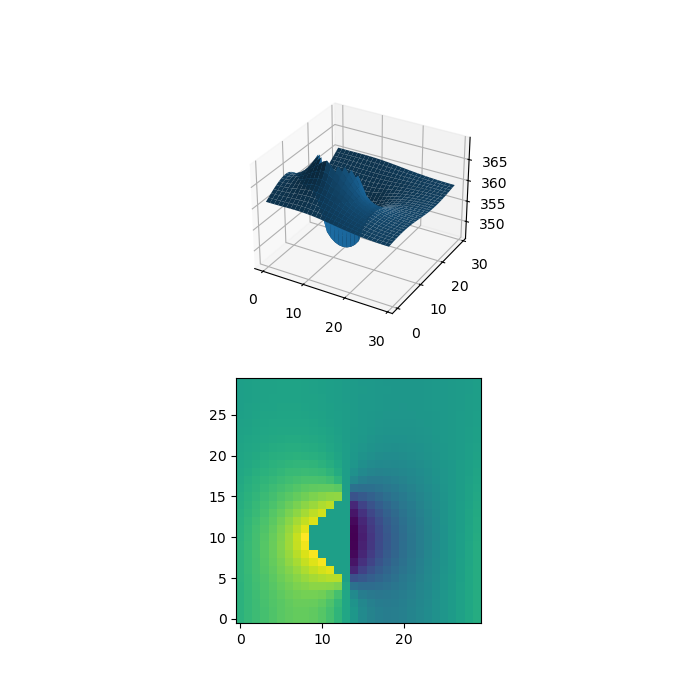

In [140]:
%matplotlib widget
import pyamg

ml = pyamg.ruge_stuben_solver(A)  # Build the multigrid hierarchy
%time x = ml.solve(b, tol=1e-8)
# x = np.linalg.solve(A,b)

# from scipy.sparse.linalg import gmres

# x, info = gmres(A, b, maxiter=10000)

mesh = np.zeros(shape=(height,width))


avg = np.average(x)

for j in range(0,height):
    for i in range(0,width):
        if obstacle[j][i]:
            mesh[j][i] = avg
            continue
        index = fluid_cell_flat_index[j][i]
        mesh[j][i] = x[index]

        # fluid_cell_flat_index[j][i] = x[index]

# mesh[1:-1,1:-1] = x.reshape((size-2,size-2))

print(x.shape)
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(211, projection='3d')
ax2 = fig.add_subplot(212)
ax2.imshow(mesh, interpolation='none', origin='lower')
# plt.imshow(mesh, interpolation='none', origin='lower')
ax.plot_surface(Y,X,mesh) 
plt.show()

In [ ]:
# np.sign(-.05)

In [ ]:
%%time
%matplotlib widget

H,W = (3*np.pi,np.pi)
size = 50

Y, X = np.meshgrid(np.arange(size), np.arange(size))

mesh = np.zeros(shape=(size,size))

step = H/(size-1)

# One sided dirichlet.
for i in range(0,size):
    mesh[i][0] = 10*np.sin(i*step)**2
    #mesh[i][size-1] = 10*np.sin(3*i*step)**2

A = np.zeros(shape=((size-2)*(size-2), (size-2)*(size-2)))

b = np.zeros((size-2)**2)

def flat_index(j,i):
    return (j-1)*(size-2) + (i-1)

for j in range(1,size-1):
    for i in range(1,size-1):
        ones = []
        rhs = 0
        if (j-1 == 0):
            rhs += -mesh[0][i]
        else:
            ones += [flat_index(j-1,i)]

        if (j+1 == size-1):
            rhs += -mesh[size-1][i]
        else:
            ones += [flat_index(j+1,i)]

        if (i-1 == 0):
            rhs += -mesh[j][0]
        else:
            ones += [flat_index(j,i-1)]

        if (i+1 == size-1):
            rhs += -mesh[j][i+1]
        else:
            ones += [flat_index(j,i+1)]
        center_flat_index = flat_index(j,i)
        A[center_flat_index][center_flat_index] = -4
        b[center_flat_index] = rhs
        for one in ones:
            A[center_flat_index][one] = 1

# print(A.shape)
# print(np.version.version)
# print(np.show_config())

# import pyamg
import pyamg

ml = pyamg.ruge_stuben_solver(A)  # Build the multigrid hierarchy
%time x = ml.solve(b, tol=1e-8)

mesh[1:-1,1:-1] = x.reshape((size-2,size-2))

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
# ax2.imshow(m, interpolation='none', origin='lower')
# plt.imshow(mesh, interpolation='none', origin='lower')
ax.plot_surface(Y,X,mesh) 
plt.show()

In [ ]:
# indices = np.array([x for x in itertools.product([-1,0,1], [-1,0,1]) if x != (0,0)]) + [1,1]
# print(indices)

m = np.array([[1,2,3],[4,5,6],[7,8,9]])
print(m)

b = m[1:3,1:3] 
b[0,0] = 10
print(m)
# print(m[indices])
